In [149]:
import pandas as pd

df = pd.read_csv("dataset.csv")

In [148]:
# Get dataframe columns
columns = df.columns

# Filter manifest columns
manifest_features = columns[1:len(columns)-33]
dfm = df[manifest_features]

# Remove warnings
pd.options.mode.chained_assignment = None

# Compute the sum of each permission
dfm.loc["total"] = dfm.sum(numeric_only=True, axis=0)

<AxesSubplot:>

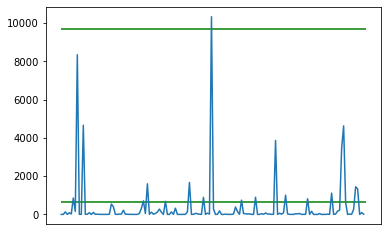

In [146]:
import matplotlib.pyplot as plt

# Extract total row from Manifest DataFrame
total = dfm.loc["total"]

# Remove x axis labels for readability
axes = plt.axes()
x_axis = axes.xaxis
x_axis.set_visible(False)

# Set tresholds
permissions_count = len(total.index)
row_count = len(dfm.index)
top_treshold = 0.9 * row_count
bottom_treshold = 0.03 * row_count

# Draw treshold
plt.hlines(y=[bottom_treshold, top_treshold], xmin=0, xmax=permissions_count, color="green")

total.plot()

In [131]:
# Filter dataframe

df_manifest = dfm.loc[:, (dfm.loc["total"]) > bottom_treshold]

In [132]:
df_id = df["id"]

dex_features = columns[len(columns)-33:]
df_dex = df[dex_features]

df = pd.merge(left=df_id, right=df_manifest, left_index=True, right_index=True, how="inner")
df = pd.merge(left=df, right=df_dex, left_index=True, right_index=True, how="inner")

df.to_csv("dataset_treshold.csv")

In [150]:
from sklearn.model_selection import train_test_split

X = df.drop(["id", "is_malicious"], axis=1)
y = df["is_malicious"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)
rf_random.fit(X_train, y_train)
# rf_pred = rf.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [167]:
params = {'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

rf_with_params = RandomForestClassifier(n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features="sqrt", max_depth=None, bootstrap=False)
rf_with_params.fit(X_train, y_train)

pred_with_params=rf_with_params.predict(X_test)

print("With Params")
print(classification_report(pred_with_params, y_test))

With Params
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1096
           1       0.90      0.96      0.93      1060

    accuracy                           0.93      2156
   macro avg       0.93      0.93      0.93      2156
weighted avg       0.93      0.93      0.93      2156



In [168]:
print(rf_with_params.feature_importances_)

[2.32381352e-06 8.46453215e-06 1.87489190e-03 3.20807911e-05
 3.65041863e-04 1.26076694e-04 1.79817596e-02 1.08586918e-03
 4.79437105e-02 1.31778660e-05 5.99226907e-05 1.14762530e-02
 1.29365049e-04 9.45019327e-05 6.31236911e-04 1.52120563e-05
 7.40194585e-04 3.33580821e-05 5.52253950e-05 9.39784314e-07
 6.76343647e-06 0.00000000e+00 2.50054037e-05 8.24313581e-06
 1.03693523e-04 2.47656877e-03 1.66905083e-03 1.60646549e-05
 2.46228201e-05 5.70477706e-05 1.24353807e-04 2.82147259e-03
 1.03892710e-04 5.14927315e-05 1.73035177e-06 6.24268359e-06
 6.37893487e-06 0.00000000e+00 2.44515734e-05 4.91576380e-04
 1.70097518e-03 3.85136100e-03 2.21729850e-04 7.41013585e-03
 2.31577226e-05 7.67140811e-04 8.41957762e-05 6.13814443e-04
 2.18407829e-03 5.70437960e-03 9.83354132e-04 5.44249994e-06
 2.67862629e-03 0.00000000e+00 3.05507878e-05 6.43506784e-04
 2.24131794e-04 2.25418227e-03 4.47552185e-06 1.67232762e-05
 2.65859793e-07 1.68387591e-06 2.81594826e-06 8.67454078e-04
 7.52648771e-03 1.089569

In [164]:
from sklearn.metrics import classification_report

print(classification_report(rf_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1080
           1       0.91      0.95      0.93      1076

    accuracy                           0.93      2156
   macro avg       0.93      0.93      0.93      2156
weighted avg       0.93      0.93      0.93      2156



In [136]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

dt_pred = dt.predict(X_test)

In [137]:
print(classification_report(dt_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1009
           1       0.88      0.86      0.87      1147

    accuracy                           0.86      2156
   macro avg       0.86      0.86      0.86      2156
weighted avg       0.86      0.86      0.86      2156



In [138]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [139]:
print(classification_report(knn_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1058
           1       0.83      0.86      0.84      1098

    accuracy                           0.84      2156
   macro avg       0.84      0.84      0.84      2156
weighted avg       0.84      0.84      0.84      2156



In [140]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(X_train, y_train)

mlp_pred = mlp.predict(X_test)

In [141]:
print(classification_report(mlp_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.63      0.76      1545
           1       0.50      0.91      0.64       611

    accuracy                           0.71      2156
   macro avg       0.72      0.77      0.70      2156
weighted avg       0.82      0.71      0.73      2156



In [142]:
svc = SVC()
svc.fit(X_train, y_train)

svc_pred = svc.predict(X_test)

In [143]:
print(classification_report(svc_pred, y_test))

              precision    recall  f1-score   support

           0       0.77      0.74      0.76      1066
           1       0.76      0.78      0.77      1090

    accuracy                           0.76      2156
   macro avg       0.76      0.76      0.76      2156
weighted avg       0.76      0.76      0.76      2156



In [124]:
from sklearn.naive_bayes import GaussianNB

gauss_nb = GaussianNB()
gauss_nb.fit(X_train, y_train)

gauss_nb_pred = gauss_nb.predict(X_test)

In [125]:
print(classification_report(gauss_nb_pred, y_test))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1436
           1       0.56      0.88      0.68       720

    accuracy                           0.73      2156
   macro avg       0.74      0.77      0.72      2156
weighted avg       0.80      0.73      0.74      2156



In [126]:
# Calculate F1 score for all models

from sklearn.metrics import f1_score

rf_score = f1_score(rf_pred, y_test)
dt_score = f1_score(dt_pred, y_test)
knn_score = f1_score(knn_pred, y_test)
mlp_score = f1_score(mlp_pred, y_test)
svc_score = f1_score(svc_pred, y_test)
gauss_nb_score = f1_score(gauss_nb_pred, y_test)

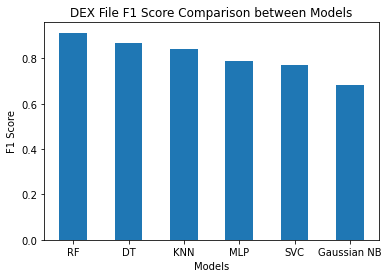

In [127]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

scores = [rf_score, dt_score, knn_score, mlp_score, svc_score, gauss_nb_score]
labels = ["RF", "DT", "KNN", "MLP", "SVC", "Gaussian NB"]

plt.bar(labels, scores, width=0.5)
plt.title("DEX File F1 Score Comparison between Models")
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.show()

In [44]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np

kf = KFold(n_splits=10, shuffle=True)

X = np.array(X)
y = np.array(y)

# f1_scores = []
# accuracy_scores = []
# recall_scores = []
# precision_scores = []
splits = []

ct = 0

for train_index, test_index in kf.split(X):
    ct += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    rf_pred = rf.predict(X_test)
    
    splits.append([accuracy_score(rf_pred, y_test), precision_score(rf_pred, y_test), recall_score(rf_pred, y_test), f1_score(rf_pred, y_test)])
    
#     f1_scores.append(f1_score(rf_pred, y_test))
#     accuracy_scores.append(accuracy_score(rf_pred, y_test))
#     recall_scores.append(recall_score(rf_pred, y_test))
#     precision_scores.append(precision_score(rf_pred, y_test))

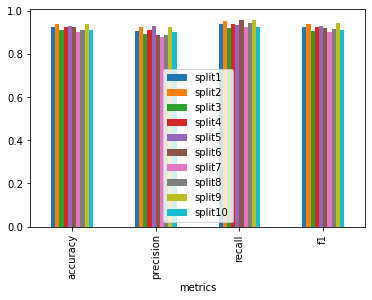

In [45]:
df = pd.DataFrame()
df["split1"] = splits[0]
df["split2"] = splits[1]
df["split3"] = splits[2]
df["split4"] = splits[3]
df["split5"] = splits[4]
df["split6"] = splits[5]
df["split7"] = splits[6]
df["split8"] = splits[7]
df["split9"] = splits[8]
df["split10"] = splits[9]

labels = ["accuracy", "precision", "recall", "f1"]
df["metrics"] = labels
cols = ["split1","split2","split3","split4","split5","split6","split7","split8","split9","split10"]
# df["model"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

ax = df.plot(x="metrics", y=cols, kind="bar")
# ax.set_ylim(0.87, 0.97)
plt.show()